# Source Data
I will build a model to predict the quality of red wine based on several characteristics of the wine. I've sourced the data for this model from Kaggle. You can find the data set [here](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).

## Downloading the Data
Kaggle has instructions to download the data using their Kagglehub API, and the first cell below does so. As a precaution, I may also provide a copy of the data in this repository (TBD) to ensure consistency and accessibility of the data. But you can always follow the instructions at Kaggle to download the data directly from them.

### Acknowledgment
I must acknowledge the providers for this data:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [96]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm

def load_data_direct_from_kagglehub() -> pd.DataFrame:
    import kagglehub

    # Download latest version
    local_path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")

    print("Path to dataset files:", local_path)

    local_dir = Path(local_path)
    assert (
        local_dir.is_dir()
    ), "Expected Kaggle to download data to a directory, but it did not."

    files = list(local_dir.iterdir())
    assert (
        file_count := len(files)
    ) == 1, f"Expected only a single file in the directory, but found {file_count}"

    data = pd.read_csv(files[0])
    return data


In [21]:
data = pd.read_csv("winequality-red.csv")
print("Successfully loaded data. Here's a basic description:")
data.describe()

Successfully loaded data. Here's a basic description:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Exploratory Data Analysis
The description above gives us a fairly good starting point for looking at this data. We can see that it is all numeric. 

### Label
The label column is called "quality", and contains discrete values from a 10 point scale (the Kaggle description for the data set speaks a bit to this). A histogram of the quality values (below), shows that most values are in the 5 to 6 range. So we might think of 5 or 6 as representing "typical" wines, while values of 7 or greater indicate higher quality or exceptional wines.

Although the values here are discrete values on a 10 point scale, their order has significance (4 is better then 3, 5 is better than 4, etc.). Consequently, in this study I will lean towards methods that focus on regression. If we wanted to turn the result into a classification after the fact, we can simply assign ranges to the output predicted values.

0    5
Name: quality, dtype: int64

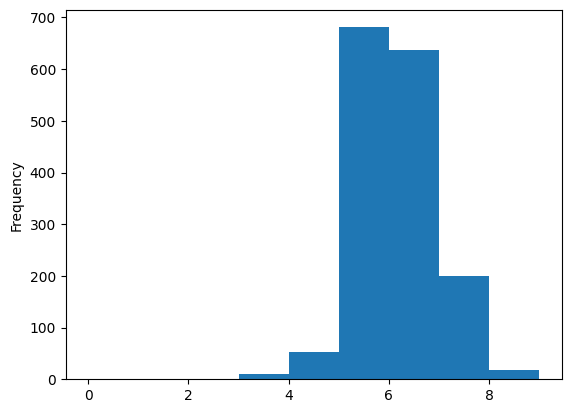

In [ ]:
data.quality.plot.hist(bins=range(10))

### Predictors
The remaining values are the predictors/features for this study. All are continuous variables. Each represents a quantitative measurement of some chemical or physical trait of the wine.

Notably, several of the predictors relate to acidity:
- fixed_acidity
- volatile_acidity
- citric_acid
- pH

A correlation matrix (below) illustrates the strength of some of these relationships. `citric_acid`, for example, has a strong positive correlation to `fixed_acidity` and a strong negative correlation to `volatile_acidity`. And pH has a strong negative correlation to `fixed_acidity` and `citric_acid`. As we proceed, we may find that models excluding some combination of these predictors may have improved accuracy.

<Axes: >

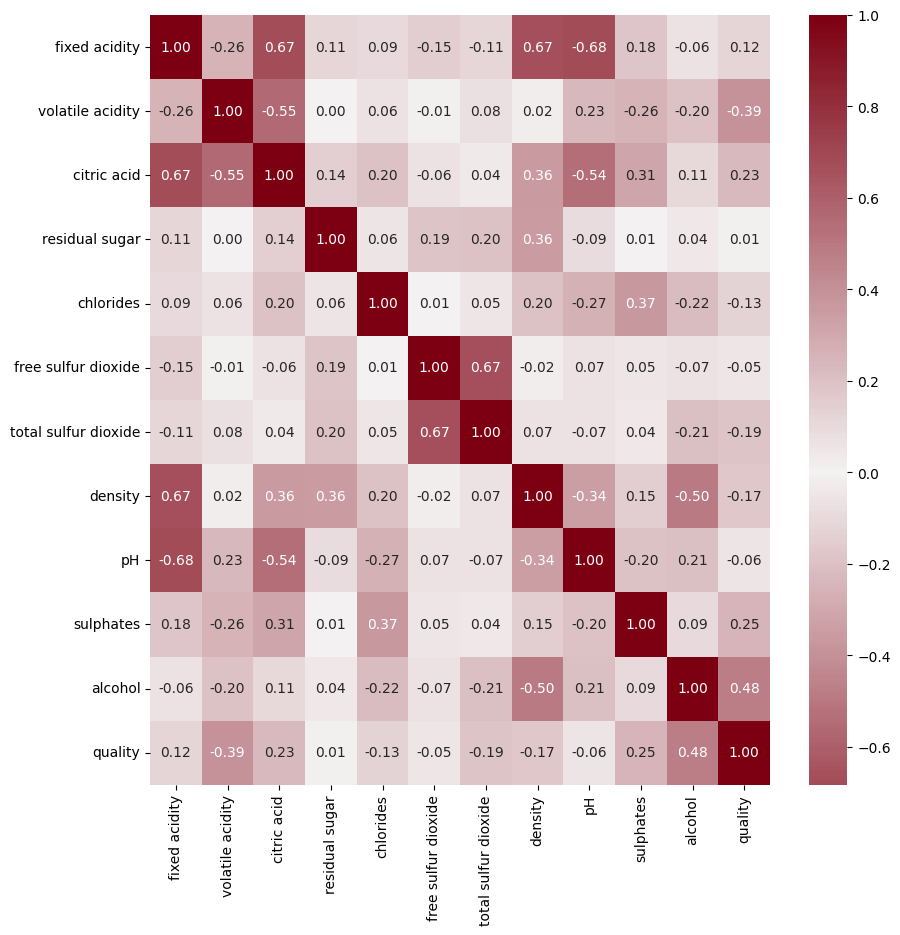

In [83]:
cm = data.corr()

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    cm,
    xticklabels=1,
    yticklabels=1,
    annot=True,
    fmt="0.2f",
    center=0.0,
    cmap=sns.diverging_palette(
        10,
        10,
        s=100,
        l=25,
        center="light",
        as_cmap=True,
    ),
)

## Splitting Data
For training and testing, I'll use 75% and 25% of the data set, respectively. With roughly 1600 cases, that gives me about 1200 to train and 400 to test with.

In [94]:
X_df = data.drop(columns="quality")
y_df = data.quality

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.25, random_state=42)



In [104]:
X_weighted_df = X_df.copy()

for col in X_weighted_df.columns:
    X_weighted_df[col] = X_weighted_df[col] / X_weighted_df[col].sum()

X_weighted_train, X_weighted_test, y_train, y_test = train_test_split(X_weighted_df, y_df, test_size=0.25, random_state=42)


In [105]:
model = sm.OLS(y_train, X_weighted_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                quality   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              8056.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):                        0.00
Time:                        15:58:16   Log-Likelihood:                         -1192.1
No. Observations:                1199   AIC:                                      2406.
Df Residuals:                    1188   BIC:                                      2462.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity           42.4977    255.191      0.167      0.868    -458.178     543.173
volatile acidity      -862.6274    118.560     -7.276      0.000   -1095.237    -630.018
citric acid            -58.5752     74.841     -0.783      0.434    -205.411      88.261
residual sugar           0.5472     56.780      0.010      0.992    -110.854     111.948
chlorides             -249.0756     65.930     -3.778      0.000    -378.429    -119.723
free sulfur dioxide    131.8706     65.657      2.008      0.045       3.054     260.687
total sulfur dioxide  -275.5298     63.133     -4.364      0.000    -399.395    -151.665
density               6706.6393   1154.618      5.809      0.000    4441.322    8971.956
pH                   -2344.5556    982.844     -2.385      0.017   -4272.858    -416.253
sulphates              834.3775    132.556      6.295      0.000     574.307    1094.448
alcohol               5082.9157    340.129     14.944      0.000    4415.596    5750.236
==============================================================================
Omnibus:                       26.033   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.079
Skew:                          -0.179   Prob(JB):                     7.29e-10
Kurtosis:                       3.845   Cond. No.                         167.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""